In [6]:
# import all necessary packages for CBOW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, spearmanr
from torchtext.vocab import GloVe
from sklearn.model_selection import train_test_split
from gensim import matutils
from numpy import dot
from sklearn.metrics import accuracy_score

ImportError: cannot import name 'triu' from 'scipy.linalg' (/opt/conda/lib/python3.9/site-packages/scipy/linalg/__init__.py)

In [5]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print device name: get_device_name()
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


In [7]:
# Load data from file and store list of sentences where sentences are list of words
class MakeSentences():
    def __init__(self, file_name):
        self.file_name = file_name
        self.sentences = self.read_file()

    def read_file(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            i=0
            for line in f:
                sentences += ([x for x in line.strip().split('.') if x!=''])
                i+=1
                if i==10000:
                    break
        return sentences

In [8]:
sentences = MakeSentences('../sa_sentences.txt').sentences
print(len(sentences))
# for sentence in sentences:
#     print(type(sentence))

11284


In [9]:
print(sentences[11283])

A froward heart shall depart from me; I will not know a wicked person


### Preprocess

In [10]:
import re
from collections import Counter

class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        self.sentences = [re.findall(r'\b\w+\b', sentence.lower()) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        stop_words = set(["the", "is", "at", "which", "on", "and", "a", "an"])
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        def simple_stem(word):
            suffixes = ["ing", "ly", "ed", "ious", "ies", "ive", "es", "s", "ment"]
            for suffix in sorted(suffixes, key=len, reverse=True):
                if word.endswith(suffix):
                    return word[:-len(suffix)]
            return word
        self.sentences = [[simple_stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word.strip()] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]


In [11]:
# preprocess
preprocess = Preprocess(sentences)
preprocess.tokenize()
preprocess.lowercase()
preprocess.remove_stop_words()
preprocess.stemmer()
preprocess.remove_punctuation()
preprocess.remove_numbers()
preprocess.remove_single_letter()
preprocess.remove_extra_spaces()
preprocess.remove_less_than_3()

print("Preprocessing done")
sentences = preprocess.sentences
print(len(sentences))

Preprocessing done
11284


### Create word index mappings

In [12]:
# Flatten list of sentences into list of words
word_list = list(itertools.chain.from_iterable(sentences))
# print(word_list)

# Create a vocabulary of words
word_freq = Counter(word_list)

# Remove words that occur less than 5 times
vocab = set(word if word_freq[word] > 0 else '<unk>' for word in word_list)
# print(vocab)

# Add padding and unknown token to vocab
vocab.add('<pad>')
vocab.add('<unk>')
vocab.add('<start>')
vocab.add('<end>')

# Print length of vocab
print("Size of vocab: ", len(vocab))

# Create word to index and index to word mapping
word_to_idx = {word:idx for idx, word in enumerate(vocab)}
idx_to_word = {idx:word for idx, word in enumerate(vocab)}

# Print most common words
print("Most common words: ", word_freq.most_common(10))

Size of vocab:  33805
Most common words:  [('for', 2225), ('with', 1959), ('was', 1786), ('that', 1728), ('has', 1351), ('from', 1288), ('his', 1073), ('after', 763), ('who', 752), ('been', 737)]


In [13]:
# Check
print(word_to_idx['intelligent'])

23080


### Create dataset (X,y)

In [14]:
# define constants
window_size = 2
sliding_window = 2 * window_size + 1
num_neg_samples = 1

# sentences = [sentences[0]]
# print(sentences)

def get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_sample):
    X = []
    y = [] 
    for sentence in sentences:
        sentence = ['<start>'] + sentence + ['<end>']
        for i in range(len(sentence)):
            target_word = sentence[i]
            context_words = []
            temp1 = max(0,i - window_size)
            temp2 = min(len(sentence)-1,i + window_size + 1)
            # print("temp1: ", temp1)
            # print("temp2: ", temp2)
            for j in range(max(0,i - window_size),min(len(sentence)-1,i + window_size)+1):
                if j != i:
                    # print(sentence[j])
                    context_words.append(sentence[j])
                # print("context words: ", context_words)

            
            # pad context words if length is less than sliding window
            if len(context_words) < sliding_window:
                context_words += ['<pad>'] * (sliding_window - len(context_words)-1)
            
            context_words.append(target_word)
            # print("length of context words: ", len(context_words))

            # get positive samples 
            positive_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in context_words]
            # print("lenght of positive samples: ", len(positive_samples))
            
            X.append(positive_samples)
            y.append(1)


            for _ in range(num_neg_samples):
                negative_samples = positive_samples[:-1]  
                neg_sample = random.choice(list(vocab))
                while neg_sample in context_words:  
                    neg_sample = random.choice(list(vocab))
                
                negative_samples.append(word_to_idx[neg_sample])  
                X.append(negative_samples)
                y.append(0)
                
    return X, y

In [15]:
print("Creating samples")
X = []
y = []
X,y = get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_samples)
print("Samples created")

Creating samples
Samples created


In [16]:
data = list(zip(X,y))
random.shuffle(data)
X,y = zip(*data)
X = np.array(X)
y = np.array(y)

In [17]:
# Save X and y
np.save('./datasets/sa_X_25k.npy', X)
np.save('./datasets/sa_y_25k.npy', y)

In [18]:
# # Load X and y
X = np.load('./datasets/sa_X_25k.npy')
y = np.load('./datasets/sa_y_25k.npy')

### Build model

In [19]:
# write the forward pass for CBOW
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # self.embeddings.weight.data.uniform_(-1, 1)

    def forward(self, x):
        # extract context and target from x
        context = x[:, :-1]
        target = x[:, -1]

        context_embedding = self.embeddings(context)
        context_embedding = torch.mean(context_embedding, dim=1)
        target_embedding = self.embeddings(target)

        score = torch.sum(context_embedding * target_embedding, dim=1)
        return F.sigmoid(score)

    def get_embeddings(self):
        out = self.embeddings.weight.data
        return out.cpu().numpy()
    
    def get_word_embedding(self, word):
        # If word is not in vocab, return unk
        if word not in word_to_idx:
            word = '<unk>'
        word_tensor = torch.LongTensor([word_to_idx[word]])
        word_tensor = word_tensor.to(next(self.parameters()).device)
        out = self.embeddings(word_tensor).data
        return out.cpu().numpy()

In [20]:
# Define parameters
vocab_size = len(vocab)
embedding_dim = 100
learning_rate = 0.001
epochs = 10
batch_size = 128

# Create model, loss function and optimizer
model = CBOW(vocab_size, embedding_dim)
model.to(device)
# Cross entropy loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define dataloader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X).long(), torch.from_numpy(y).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [21]:
for i, (inputs, targets) in enumerate(dataloader):
    print(inputs)
    print(targets)
    break

tensor([[30455, 30931, 11056, 24140, 19192],
        [19867, 13391,  6355, 24755,  3882],
        [  569, 19451, 21504,  6439, 24605],
        [20828, 28144,  7256, 15823, 22046],
        [22364, 30472, 18309, 18309,   569],
        [24260, 27854, 11444, 20263, 25917],
        [32132, 10013, 27902, 15988, 16880],
        [13971, 32977,  9745,  2159, 19339],
        [ 8358, 30931, 21613,  6439, 27338],
        [29970, 13515, 20567, 26493, 20322],
        [13230, 18928,  5517, 24140, 11732],
        [ 4124, 16667, 18309, 18309, 24145],
        [21700, 26250, 11685, 33675,  1321],
        [25929,   111, 25929, 30643,  8157],
        [ 4250,  2613, 24140, 18309, 29607],
        [16966,  3672, 17914, 14611, 18521],
        [10502,  4057, 24819, 27338, 22364],
        [31728,   230,  4882,  1140,  6388],
        [ 4524, 12386, 25250, 22377,  4666],
        [18810, 23985, 24140, 18309,  5170],
        [16077, 32243, 27579, 32730, 24358],
        [24171, 14989, 17083, 14989, 28093],
        [ 

In [22]:
# Train CBOW model
def train(model, criterion, optimizer, dataloader, epochs):
    train_losses = []
    for epoch in range(epochs):
        train_loss = 0
        train_preds = []
        labels = []
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # get predictions
            preds = [1 if x > 0.5 else 0 for x in outputs]
            train_preds.extend(preds)
            targets = targets.detach().cpu().numpy()
            labels.extend(targets)
        
        train_loss /= len(dataloader)
        train_losses.append(train_loss)
        print("Epoch: ", epoch+1, "Loss: ", train_loss)
    return train_losses

In [23]:
# Train model
train_losses = train(model, criterion, optimizer, dataloader, epochs)

Epoch:  1 Loss:  1.8673759465151676
Epoch:  2 Loss:  1.215479940959753
Epoch:  3 Loss:  0.7811625860706826
Epoch:  4 Loss:  0.4893969201249845
Epoch:  5 Loss:  0.29674907025911884
Epoch:  6 Loss:  0.1758963936677332
Epoch:  7 Loss:  0.10368485790592588
Epoch:  8 Loss:  0.061948498844125746
Epoch:  9 Loss:  0.03825539657506974
Epoch:  10 Loss:  0.02453198489282137


In [24]:
# Function to plot train accuracy
def plot_train_losses(train_losses):
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.savefig('./plots/cbow_train_losses_sa.png')
    plt.show()

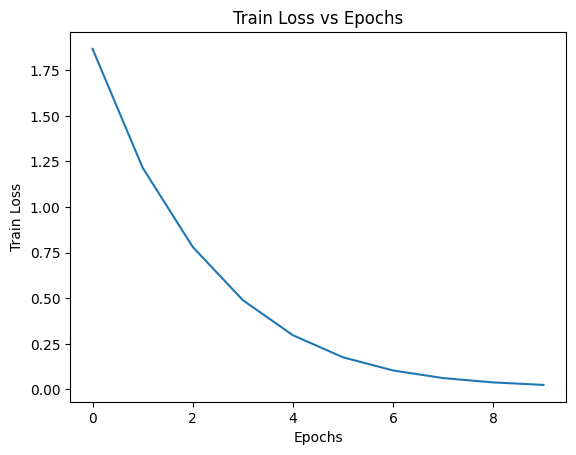

In [25]:
# Call function to plot train accuracy
plot_train_losses(train_losses)

In [26]:
# Save model
torch.save(model.state_dict(), './partA_pth/cbow_sa_25k_100_001.pth')

In [27]:
# Load model
model = CBOW(vocab_size, embedding_dim)
model.load_state_dict(torch.load('./partA_pth/cbow_sa_25k_100_001.pth'))
model.to(device)

CBOW(
  (embeddings): Embedding(33805, 100)
)

### Test model with Simlex-999 dataset

In [28]:
# Load into dataframe
df = pd.read_csv('../SimLex-999/SimLex-999.txt', sep='\t')
print(df.head())

   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


In [29]:
# Print 2nd row word1
print(df['word1'][1])

smart


In [30]:
# Get word embeddings
sample_embedding = model.get_word_embedding(df['word1'][1])
print(sample_embedding.shape)
sample_embedding = sample_embedding.squeeze()
print(sample_embedding.shape)
print(sample_embedding)
sample_embedding = sample_embedding.reshape(1,-1)
print(sample_embedding.shape)

(1, 100)
(100,)
[-0.8985697   1.1503736  -1.171949    0.40460062  0.5095849  -0.8688809
 -0.9613805   1.0171666  -0.5817347  -0.49532703  0.53432095 -1.4444683
  2.3393843   0.22620761  0.8623778   1.2113949   0.853483    1.0019602
 -1.2342533   0.40411726  0.56452835 -1.395803    0.7843319  -0.54525524
  0.84928983 -0.31465015  0.313101   -0.2740316   0.96695185  1.316194
  1.3397113   1.364346    0.44744095 -0.0880265  -0.70664835  1.4759094
 -0.3938875  -1.132068   -0.06704634 -1.420919   -0.37628746  0.28492716
 -0.7071364   1.0334513  -1.2303814   0.19241108  0.9320706  -0.5177427
 -1.0582789  -0.7194619  -0.27903485  0.02689491 -0.29027     0.09829962
 -0.11095417 -1.3037634  -0.6270385  -1.6533645   0.18877098 -0.7446808
 -0.62412435  0.29670063  0.9443103   0.0335416   0.28963447  1.065468
  1.0228721  -1.7138721   0.40128204  1.5049978   0.6305159   0.808397
  0.266485    0.03889744 -1.6778785  -0.1122261   1.2560952  -0.2625456
  1.3520668   0.08819967  1.1177108   0.6461465 

In [31]:
import numpy as np

# Check similarity between two words
word1 = df['word1'][1]
word2 = df['word1'][1]

# Use gensim or any other model to get word embeddings
w1 = model.get_word_embedding(word1).squeeze()
w2 = model.get_word_embedding(word2).squeeze()

print(type(w1))

# Calculate cosine similarity using numpy
def unitvec(vec):
    return vec / np.linalg.norm(vec)

sim = np.dot(unitvec(w1), unitvec(w2))
print(sim)


<class 'numpy.ndarray'>
1.0000001


In [32]:
# Function to check if word is in vocab
def check_vocab(word):
    if word in vocab:
        return True
    else:
        return False

### Similarity Measures

In [33]:
# Function to get cosine similarity
def cos_similarity(word1_embedding, word2_embedding):
    def unitvec(vec):
        return vec / np.linalg.norm(vec)

    ans = np.dot(unitvec(word1_embedding), unitvec(word2_embedding))
    return ans

# Function to get Pearson correlation
def pearson_correlation(word1_embedding, word2_embedding):
    emb1 = np.array(word1_embedding)
    emb2 = np.array(word2_embedding)

    correlation, _ = pearsonr(emb1, emb2)
    return correlation

In [34]:
def test_sim(df, model, lemmatizer, stemmer):
    cosine_similarity_scores = []
    pearson_correlation_scores = []
    simlex_scores = []
    not_in_vocab = 0
  
    for _, row in df.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        form = row['POS']
        form = form.lower()
       
        # Check if word is in vocab
        if not check_vocab(word1) or not check_vocab(word2):
            not_in_vocab += 1

        # Get embeddings
        word1_embedding = model.get_word_embedding(word1).squeeze()
        word2_embedding = model.get_word_embedding(word2).squeeze()

        # Get cosine similarity
        cosine_similarity_scores.append(cos_similarity(word1_embedding, word2_embedding))
        
        # Get pearson correlation
        pearson_correlation_scores.append(pearson_correlation(word1_embedding, word2_embedding))

        # Get simlex score
        simlex_scores.append(row['SimLex999'])
        
    return cosine_similarity_scores, pearson_correlation_scores, simlex_scores, not_in_vocab

In [35]:
# Get cosine similarity and pearson correlation scores
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
cosine_similarity_scores, pearson_correlation_scores, simlex_scores, not_in_vocab = test_sim(df, model, lemmatizer, stemmer)

In [36]:
# Check cosine similarity and pearson correlation scores
print(type(cosine_similarity_scores))
print(type(pearson_correlation_scores))
print(type(simlex_scores))

<class 'list'>
<class 'list'>
<class 'list'>


### Initial Spearman

In [37]:
# Funtcion to get spearman correlation using cosine similarity scores
def spearman_correlation(cosine_similarity_scores, simlex_scores):
    # Scale cosine similarity scores to 0-10
    cosine_similarity_scores = np.array(cosine_similarity_scores)
    cosine_similarity_scores = (1+cosine_similarity_scores)*5
    simlex_scores = np.array(simlex_scores)

    correlation, _ = spearmanr(cosine_similarity_scores, simlex_scores)
    return correlation    

In [38]:
# Print the initial spearman correlation
spearman_value_sim = spearman_correlation(cosine_similarity_scores, simlex_scores)

print("Initial Spearman correlation Sim: ", spearman_value_sim)

Initial Spearman correlation Sim:  0.010828562909202805


In [39]:
# Print the number of data points not in vocab
print("Number of data points not in vocab: ", not_in_vocab)

Number of data points not in vocab:  106


In [40]:
# Make a dataframe of cosine similarity scores and pearson correlation scores along with Simlex-999 scores and Assoc(USF)
simlex_scores = df['SimLex999']
assoc_scores = df['Assoc(USF)']
cosine_similarity_scores = np.array(cosine_similarity_scores)
pearson_correlation_scores = np.array(pearson_correlation_scores)
simlex_scores = np.array(simlex_scores)
assoc_scores = np.array(assoc_scores)
# print(cosine_similarity_scores.shape)
# print(pearson_correlation_scores.shape)

# Make a dataframe along with word1, word2, POS, SimLex-999 scores, Assoc(USF), cosine similarity scores and pearson correlation scores
datat = {'word1': df['word1'], 'word2': df['word2'], 'POS': df['POS'], 'SimLex999': simlex_scores, 'Assoc(USF)': assoc_scores, 'Cosine Similarity': cosine_similarity_scores, 'Pearson Correlation': pearson_correlation_scores}
ndf = pd.DataFrame(data=datat)
print(ndf.head())

   word1        word2 POS  SimLex999  Assoc(USF)  Cosine Similarity  \
0    old          new   A       1.58        7.25           0.100814   
1  smart  intelligent   A       9.20        7.11           0.052994   
2   hard    difficult   A       8.77        5.94          -0.053810   
3  happy     cheerful   A       9.55        5.85           0.000561   
4   hard         easy   A       0.95        5.82          -0.084562   

   Pearson Correlation  
0             0.101021  
1             0.057858  
2            -0.043113  
3             0.002174  
4            -0.063077  


In [41]:
# Print df
print(ndf)

      word1        word2 POS  SimLex999  Assoc(USF)  Cosine Similarity  \
0       old          new   A       1.58        7.25           0.100814   
1     smart  intelligent   A       9.20        7.11           0.052994   
2      hard    difficult   A       8.77        5.94          -0.053810   
3     happy     cheerful   A       9.55        5.85           0.000561   
4      hard         easy   A       0.95        5.82          -0.084562   
..      ...          ...  ..        ...         ...                ...   
994    join      acquire   V       2.85        0.00           0.056240   
995    send       attend   V       1.67        0.00           0.023187   
996  gather       attend   V       4.80        0.00          -0.144740   
997  absorb     withdraw   V       2.97        0.00          -0.098706   
998  attend       arrive   V       6.08        0.00           0.020983   

     Pearson Correlation  
0               0.101021  
1               0.057858  
2              -0.043113  
3  

### Build the Model

In [42]:
# Create Dataset
def create_dataset(df, model):
    # Create a list of tuples
    emb1 = []
    emb2 = []
    simlex_scores = []
    assoc_scores = []

    for _, row in df.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        emb1.append(torch.tensor(model.get_word_embedding(word1).squeeze()))
        emb2.append(torch.tensor(model.get_word_embedding(word2).squeeze()))
        simlex_scores.append(row['SimLex999'])
        assoc_scores.append(row['Assoc(USF)'])
    
    # print(emb1[0].shape)
    emb1_stack = torch.stack(emb1)
    emb2_stack = torch.stack(emb2)
    
    return emb1_stack, emb2_stack, torch.tensor(simlex_scores, dtype=torch.float), torch.tensor(assoc_scores, dtype=torch.float)

In [43]:
# Call create_dataset
train_df, test_df = train_test_split(ndf, test_size=0.1, random_state=42)
train_emb1, train_emb2, train_simlex_scores, train_assoc_scores = create_dataset(train_df, model)
test_emb1, test_emb2, test_simlex_scores, test_assoc_scores = create_dataset(test_df, model)

In [44]:
# check train_emb1
print(train_emb1.shape)
print(train_simlex_scores.shape)

torch.Size([899, 100])
torch.Size([899])


In [45]:
# Creare TensorDataset
train_dataset = torch.utils.data.TensorDataset(train_emb1, train_emb2, train_simlex_scores, train_assoc_scores)
test_dataset = torch.utils.data.TensorDataset(test_emb1, test_emb2, test_simlex_scores, test_assoc_scores)

In [46]:
# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [47]:
# Class that takes CBOW embeddings, and outputs similarity scores: loss is MSE between predicted similarity scores and actual similarity scores(Simlex-999)
class RegressionModel(nn.Module):
    def __init__(self, embedding_dim):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(2*embedding_dim, 50)
        self.linear2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, emb1, emb2):
        emb = torch.cat((emb1, emb2), dim=1)

        out = self.linear1(emb)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)

        # Project the output between 0 and 10
        out = torch.sigmoid(out)
        out = out*10
        return out

In [48]:
# Model Parameters
embedding_dim = 100
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Initialize model
lmodel = RegressionModel(embedding_dim).to(device)
# Define loss function
criterion = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(lmodel.parameters(), lr=learning_rate, weight_decay=0.01) # weight_decay is L2 regularization

In [49]:
# Function to train model
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss = 0.0
    for epoch in range(num_epochs):
        for emb1, emb2, simlex_scores, assoc_scores in train_loader:
            emb1 = emb1.to(device)
            emb2 = emb2.to(device)
            simlex_scores = simlex_scores.to(device)
            assoc_scores = assoc_scores.to(device)
            # Forward pass
            outputs = model(emb1, emb2)
            
            simlex_scores = simlex_scores.unsqueeze(1)
            # print(outputs[0])
            loss = criterion(outputs, simlex_scores)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        print("Epoch: {}, Train_Loss: {}".format(epoch+1, train_loss))

In [50]:
# Train model
train(lmodel, train_loader, criterion, optimizer, num_epochs)

Epoch: 1, Train_Loss: 7.328326685675259
Epoch: 2, Train_Loss: 6.935820891372372
Epoch: 3, Train_Loss: 6.660975968492169
Epoch: 4, Train_Loss: 6.007148135518621
Epoch: 5, Train_Loss: 5.6681180448647055
Epoch: 6, Train_Loss: 5.324617461402237
Epoch: 7, Train_Loss: 5.140256777441331
Epoch: 8, Train_Loss: 4.877378599912127
Epoch: 9, Train_Loss: 4.731771539582268
Epoch: 10, Train_Loss: 4.387016668776447
Epoch: 11, Train_Loss: 4.288803651924098
Epoch: 12, Train_Loss: 4.138971849248161
Epoch: 13, Train_Loss: 3.634881613034125
Epoch: 14, Train_Loss: 3.5744066114185227
Epoch: 15, Train_Loss: 3.3835822216222957
Epoch: 16, Train_Loss: 3.1677909756239475
Epoch: 17, Train_Loss: 3.2002465261280406
Epoch: 18, Train_Loss: 3.219402804913397
Epoch: 19, Train_Loss: 2.792074734278872
Epoch: 20, Train_Loss: 2.599147440863353
Epoch: 21, Train_Loss: 2.5426834534595995
Epoch: 22, Train_Loss: 2.731941201601188
Epoch: 23, Train_Loss: 2.4921907446272673
Epoch: 24, Train_Loss: 2.689227840891814
Epoch: 25, Train_L

In [52]:
# Function to test model, Calculate test loss and Spearman correlation
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    true_simlex_scores = []
    pred_simlex_scores = []
    for emb1, emb2, simlex_scores, assoc_scores in test_loader:
        emb1 = emb1.to(device)
        emb2 = emb2.to(device)
        simlex_scores = simlex_scores.to(device)
        assoc_scores = assoc_scores.to(device)
        # Forward pass
        outputs = model(emb1, emb2)
        simlex_scores = simlex_scores.unsqueeze(1)
        loss = criterion(outputs, simlex_scores)
        test_loss += loss.item()

        # Get true labels and predicted labels
        true_simlex_scores.extend(simlex_scores.cpu().detach().numpy().tolist())
        pred_simlex_scores.extend(outputs.cpu().detach().numpy().tolist())

    test_loss /= len(test_loader)
    print("Test_Loss: {}".format(test_loss))
    # Calculate Spearman correlation
    # print("True Simlex scores: ", true_simlex_scores)
    # print("Predicted Simlex scores: ", pred_simlex_scores)

    true_simlex_scores = np.array(true_simlex_scores)
    pred_simlex_scores = np.array(pred_simlex_scores)
    spear = spearmanr(true_simlex_scores, pred_simlex_scores)
    print("Spearman correlation: {}".format(spear[0]))

In [53]:
# Test model
test(lmodel, test_loader, criterion)

Test_Loss: 9.417875051498413
Spearman correlation: 0.013615892619430426


In [56]:
%dropzone -p -src 'cbow_sa.ipynb' -tgt 'cbow_sa.ipynb'

HTML(value='')

Host key verification failed.
Connection closed


DownloadWidget(children=(HBox(children=(Password(description='Dropzone Password:', style=DescriptionStyle(desc…